In [ ]:
print(f"Number of samples: {combined_features.shape[0]}")
print(X_train.shape[0])  # To print the number of training samples
print(X_test.shape[0])   # To print the number of testing samples

NameError: name 'combined_features' is not defined

first load this dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
ddos_path = '/content/drive/MyDrive/dataset/cicddos2019_dataset.csv'
bitcoin_path = '/content/drive/MyDrive/dataset/bitcoin.csv'

# Load datasets
#ddos_data = pd.read_csv('cicddos2019_dataset.csv')
#bitcoin_data = pd.read_csv('bitcoin.csv')
# Load datasets from Google Drive
ddos_data = pd.read_csv(ddos_path)
bitcoin_data = pd.read_csv(bitcoin_path)

# Preprocess DDoS dataset
ddos_data = ddos_data.dropna()
ddos_data['DDoS_binary'] = (ddos_data['Class'] == 'Attack').astype(int)
ddos_features = ddos_data[[
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Fwd Packets Length Total', 'Bwd Packets Length Total',
    'Flow Bytes/s', 'Flow Packets/s'
]].copy()
ddos_features['Label'] = ddos_data['DDoS_binary']

# Preprocess Bitcoin dataset
bitcoin_data = bitcoin_data.drop(columns=['tx_hash'], errors='ignore')
bitcoin_data = bitcoin_data.apply(pd.to_numeric, errors='coerce')
bitcoin_data = bitcoin_data.dropna()
bitcoin_threshold = bitcoin_data['indegree'].median()
bitcoin_data['Bitcoin_binary'] = (bitcoin_data['indegree'] > bitcoin_threshold).astype(int)
bitcoin_features = bitcoin_data[[
    'indegree', 'outdegree', 'in_btc', 'out_btc',
    'total_btc', 'mean_in_btc', 'mean_out_btc'
]].copy()
bitcoin_features.rename(columns={
    'indegree': 'Total Fwd Packets',
    'outdegree': 'Total Backward Packets',
    'in_btc': 'Fwd Packets Length Total',
    'out_btc': 'Bwd Packets Length Total',
    'total_btc': 'Flow Duration',
    'mean_in_btc': 'Flow Bytes/s',
    'mean_out_btc': 'Flow Packets/s'
}, inplace=True)
bitcoin_features['Label'] = bitcoin_data['Bitcoin_binary']

# Combine datasets
combined_features = pd.concat([ddos_features, bitcoin_features], ignore_index=True)

# Feature scaling
scaler = StandardScaler()
X = combined_features.drop(columns=['Label'])
X_scaled = scaler.fit_transform(X)
y = combined_features['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
import os

print(os.path.exists(ddos_path))  # Should return True if the file exists
print(os.path.exists(bitcoin_path))

True
True


In [ ]:
first_10_rows = combined_features.head(10)
print(first_10_rows)

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       216631.0                  6                       0   
1            2.0                  2                       0   
2           48.0                  2                       0   
3       107319.0                  4                       0   
4       107271.0                  4                       0   
5           48.0                  2                       0   
6            1.0                  2                       0   
7       109142.0                  4                       0   
8            1.0                  2                       0   
9       215834.0                  6                       0   

   Fwd Packets Length Total  Bwd Packets Length Total  Flow Bytes/s  \
0                    2088.0                       0.0  9.638510e+03   
1                     802.0                       0.0  4.010000e+08   
2                     766.0                       0.0  1.595833e+07   
3                    1

In [ ]:
# Save the combined features to a CSV file
combined_features.to_csv('/content/combined_features.csv', index=False)

# Optionally, display the file path where it was saved
print("File saved as /content/combined_features.csv")

File saved as /content/combined_features.csv


In [ ]:
from google.colab import files
files.download('/content/combined_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: Load combined dataset
combined = pd.read_csv('/content/combined_features.csv')

# If you already have labels in your dataset (e.g., last column)
# Separate features and labels
X = combined.drop('Label', axis=1)  # Replace 'label' with your actual column name
y = combined['Label']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally save to CSVs
X_train.to_csv('/content/X_train.csv', index=False)
X_test.to_csv('/content/X_test.csv', index=False)
y_train.to_csv('/content/y_train.csv', index=False)
y_test.to_csv('/content/y_test.csv', index=False)

# Download files (if using Colab)
from google.colab import files
files.download('/content/X_train.csv')
files.download('/content/X_test.csv')
files.download('/content/y_train.csv')
files.download('/content/y_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=15, batch_size=128, validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

model.save("lstm_model.h5")
print("LSTM model saved as 'lstm_model.h5'")


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2913/2913 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8656 - loss: 0.3707 - val_accuracy: 0.9522 - val_loss: 0.1490
Epoch 2/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9517 - loss: 0.1415 - val_accuracy: 0.9541 - val_loss: 0.1283
Epoch 3/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9541 - loss: 0.1225 - val_accuracy: 0.9557 - val_loss: 0.1207
Epoch 4/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9557 - loss: 0.1183 - val_accuracy: 0.9574 - val_loss: 0.1179
Epoch 5/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9568 - loss: 0.1162 - val_accuracy: 0.9555 - val_loss: 0.1154
Epoch 6/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9572 - loss: 0.1140 - val_accuracy: 0.9551 - val_loss: 0.1139
Epoch 7/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9571 - loss: 0.1122 - val_accuracy: 0.9590 - val_loss: 0.1133
Epoch 8/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9583 - loss: 0.1112 - val_

LSTM model saved as 'lstm_model.h5'


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# Evaluate the model
y_pred = (model.predict(X_test_lstm) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='s', color='red', alpha=0.7)
plt.title('LSTM Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', color='green', alpha=0.7)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s', color='orange', alpha=0.7)
plt.title('LSTM Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='s', color='red', alpha=0.7)
plt.title('LSTM Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', color='green', alpha=0.7)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s', color='orange', alpha=0.7)
plt.title('LSTM Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# # Confusion Matrix Visualization
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title("Confusion Matrix", fontsize=14)
# plt.xlabel("Predicted Label", fontsize=12)
# plt.ylabel("True Label", fontsize=12)
# plt.show()

# # ROC Curve
# y_pred_prob = model.predict(X_test_lstm).ravel()
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.legend(loc='lower right')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()


NameError: name 'model' is not defined

CNN MODEL

PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set paths to datasets
ddos_path = '/content/drive/MyDrive/dataset/cicddos2019_dataset.csv'
bitcoin_path = '/content/drive/MyDrive/dataset/bitcoin.csv'

# Load datasets
ddos_data = pd.read_csv(ddos_path)
bitcoin_data = pd.read_csv(bitcoin_path)

# Preprocess DDoS dataset
ddos_data = ddos_data.dropna()
ddos_data['DDoS_binary'] = (ddos_data['Class'] == 'Attack').astype(int)
ddos_features = ddos_data[[
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Fwd Packets Length Total', 'Bwd Packets Length Total',
    'Flow Bytes/s', 'Flow Packets/s'
]].copy()
ddos_features['Label'] = ddos_data['DDoS_binary']

# Preprocess Bitcoin dataset
bitcoin_data = bitcoin_data.drop(columns=['tx_hash'], errors='ignore')
bitcoin_data = bitcoin_data.apply(pd.to_numeric, errors='coerce')
bitcoin_data = bitcoin_data.dropna()
bitcoin_threshold = bitcoin_data['indegree'].median()
bitcoin_data['Bitcoin_binary'] = (bitcoin_data['indegree'] > bitcoin_threshold).astype(int)
bitcoin_features = bitcoin_data[[
    'indegree', 'outdegree', 'in_btc', 'out_btc',
    'total_btc', 'mean_in_btc', 'mean_out_btc'
]].copy()
bitcoin_features.rename(columns={
    'indegree': 'Total Fwd Packets',
    'outdegree': 'Total Backward Packets',
    'in_btc': 'Fwd Packets Length Total',
    'out_btc': 'Bwd Packets Length Total',
    'total_btc': 'Flow Duration',
    'mean_in_btc': 'Flow Bytes/s',
    'mean_out_btc': 'Flow Packets/s'
}, inplace=True)
bitcoin_features['Label'] = bitcoin_data['Bitcoin_binary']

# Combine datasets
combined_features = pd.concat([ddos_features, bitcoin_features], ignore_index=True)

# Separate features and labels
X = combined_features.drop(columns=['Label'])
y = combined_features['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

print("Preprocessing completed successfully!")


Preprocessing completed successfully!


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same')) # Add padding='same'
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')) # Add padding='same'
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("CNN model built and compiled successfully!")

CNN model built and compiled successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAINING

In [ ]:
import numpy as np
import tensorflow as tf

# Reshape data for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

print("CNN model trained successfully!")

cnn_model.save('cnn_model.h5', save_format='h5', include_optimizer=False)
print("CNN model saved as 'cnn_model.h5'")
import joblib

# Save scaler object
joblib.dump(scaler, 'scaler.save')

# Also print mean and scale for manual use
print("Mean:", scaler.mean_)
print("Scale:", scaler.scale_)

Epoch 1/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9102 - loss: 0.2291 - val_accuracy: 0.9685 - val_loss: 0.0991
Epoch 2/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.9656 - loss: 0.1008 - val_accuracy: 0.9773 - val_loss: 0.0766
Epoch 3/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9745 - loss: 0.0803 - val_accuracy: 0.9804 - val_loss: 0.0639
Epoch 4/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9770 - loss: 0.0738 - val_accuracy: 0.9764 - val_loss: 0.0738
Epoch 5/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9765 - loss: 0.0746 - val_accuracy: 0.9818 - val_loss: 0.0572
Epoch 6/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9791 - loss: 0.0686 - val_accuracy: 0.9817 - val_loss: 0.0528
Epoch 7/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9813 - loss: 0.0631 - val_accuracy: 0.9858 - val_loss: 0.0500
Epoch 8/15
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9800 - loss: 0

CNN model trained successfully!
CNN model saved as 'cnn_model.h5'
Mean: [6.22364171e+06 1.81834005e+01 2.14580104e+00 7.00549639e+03
 1.24501256e+03 5.46007701e+07 9.38371584e+04]
Scale: [1.86667158e+07 1.68916968e+02 4.85105743e+01 2.99348222e+04
 9.15681868e+04 2.87808999e+08 3.60788534e+05]


TESTING

3642/3642 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
CNN Model Accuracy: 98.78%
              precision    recall  f1-score       support
0              0.982620  0.987696  0.985151   47625.00000
1              0.991463  0.987922  0.989690   68888.00000
accuracy       0.987830  0.987830  0.987830       0.98783
macro avg      0.987041  0.987809  0.987420  116513.00000
weighted avg   0.987848  0.987830  0.987834  116513.00000


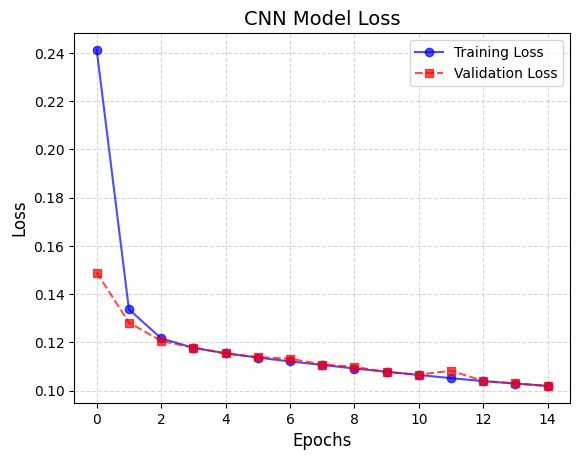

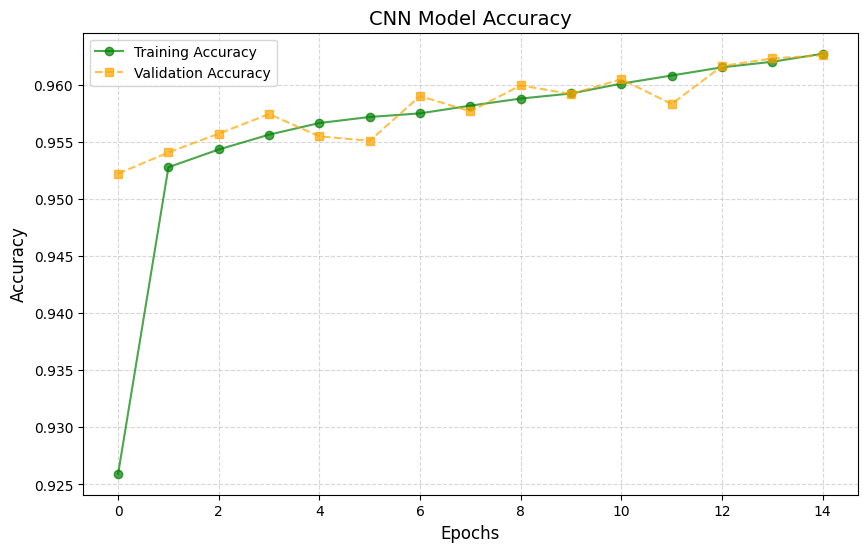

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
print(f'CNN Model Accuracy: {cnn_accuracy * 100:.2f}%')

# Classification Report
cnn_report = classification_report(y_test, y_pred_cnn, output_dict=True)
cnn_report_df = pd.DataFrame(cnn_report).transpose()
print(cnn_report_df)

# plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='s', color='red', alpha=0.7)
plt.title('CNN Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', color='green', alpha=0.7)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s', color='orange', alpha=0.7)
plt.title('CNN Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# # Confusion Matrix Visualization
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title("Confusion Matrix", fontsize=14)
# plt.xlabel("Predicted Label", fontsize=12)
# plt.ylabel("True Label", fontsize=12)
# plt.show()

# # ROC Curve
# y_pred_prob = model.predict(X_test_lstm).ravel()
# fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.legend(loc='lower right')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()


In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


HYBRID MODEL

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

# Load datasets
ddos_path = '/content/drive/MyDrive/dataset/cicddos2019_dataset.csv'
bitcoin_path = '/content/drive/MyDrive/dataset/bitcoin.csv'

ddos_data = pd.read_csv(ddos_path)
bitcoin_data = pd.read_csv(bitcoin_path)

# Preprocess DDoS dataset
ddos_data = ddos_data.dropna()
ddos_data['DDoS_binary'] = (ddos_data['Class'] == 'Attack').astype(int)
ddos_features = ddos_data[[
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Fwd Packets Length Total', 'Bwd Packets Length Total',
    'Flow Bytes/s', 'Flow Packets/s'
]].copy()
ddos_features['Label'] = ddos_data['DDoS_binary']

# Preprocess Bitcoin dataset
bitcoin_data = bitcoin_data.drop(columns=['tx_hash'], errors='ignore')
bitcoin_data = bitcoin_data.apply(pd.to_numeric, errors='coerce')
bitcoin_data = bitcoin_data.dropna()
bitcoin_threshold = bitcoin_data['indegree'].median()
bitcoin_data['Bitcoin_binary'] = (bitcoin_data['indegree'] > bitcoin_threshold).astype(int)
bitcoin_features = bitcoin_data[[
    'indegree', 'outdegree', 'in_btc', 'out_btc',
    'total_btc', 'mean_in_btc', 'mean_out_btc'
]].copy()
bitcoin_features.rename(columns={
    'indegree': 'Total Fwd Packets',
    'outdegree': 'Total Backward Packets',
    'in_btc': 'Fwd Packets Length Total',
    'out_btc': 'Bwd Packets Length Total',
    'total_btc': 'Flow Duration',
    'mean_in_btc': 'Flow Bytes/s',
    'mean_out_btc': 'Flow Packets/s'
}, inplace=True)
bitcoin_features['Label'] = bitcoin_data['Bitcoin_binary']

# Combine datasets
combined_features = pd.concat([ddos_features, bitcoin_features], ignore_index=True)

# Feature scaling
scaler = StandardScaler()
X = combined_features.drop(columns=['Label'])
X_scaled = scaler.fit_transform(X)
y = combined_features['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM
n_features = X_train.shape[1]
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, n_features))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, n_features))

TRAINING

In [ ]:
!pip install keras-tuner --upgrade
import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperParameters
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Hyperparameter tuning function
def build_hybrid_model(hp):
    input_layer = Input(shape=(1, n_features))

    # CNN branch
    cnn_layer = Conv1D(filters=hp.Int('filters', 32, 128, step=32), kernel_size=3, activation='relu', padding='same')(input_layer)
    cnn_layer = MaxPooling1D(pool_size=1)(cnn_layer)
    cnn_layer = BatchNormalization()(cnn_layer)
    cnn_layer = Dropout(hp.Float('cnn_dropout', 0.2, 0.5, step=0.1))(cnn_layer)
    cnn_layer = Conv1D(filters=hp.Int('filters_2', 32, 128, step=32), kernel_size=3, activation='relu', padding='same')(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layer = Dropout(hp.Float('cnn_dropout_2', 0.2, 0.5, step=0.1))(cnn_layer)

    # LSTM branch
    lstm_layer = LSTM(units=hp.Int('lstm_units', 50, 150, step=50), return_sequences=False,
                      dropout=hp.Float('lstm_dropout', 0.2, 0.5, step=0.1), recurrent_dropout=0.2)(input_layer)

    # Combine CNN and LSTM branches
    combined = concatenate([cnn_layer, lstm_layer])
    dense_layer = Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu')(combined)
    dense_layer = BatchNormalization()(dense_layer)
    dense_layer = Dropout(hp.Float('dense_dropout', 0.3, 0.6, step=0.1))(dense_layer)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])),
                  loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# # Initialize HyperParameters
hp = HyperParameters()

# # Random Search
tuner = kt.RandomSearch(
    build_hybrid_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='hybrid_tuning',
    project_name='ddos_bitcoin_detection'
)
# Fit the tuner
tuner.search(
    X_train_lstm, y_train,
    epochs=15,
    batch_size=hp.Choice('batch_size', [256]),
    validation_data=(X_test_lstm, y_test)
)

# Get the best model and hyperparameters
best_hybrid_model = tuner.get_best_models(num_models=1)[0]

# Train the best model (no early stopping)
training_history = best_hybrid_model.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_test_lstm, y_test)
)

# Display best hyperparameters
print(f"Best hyperparameters: {tuner.get_best_hyperparameters(num_trials=1)[0].values}")
# Save the trained best hybrid model
best_hybrid_model.save('hybrid_model.h5', save_format='h5', include_optimizer=False)
print("Hybrid model saved as 'hybrid_model.h5'")
import joblib

# Save scaler object
joblib.dump(scaler, 'scaler.save')

# Also print mean and scale for manual use
print("Mean:", scaler.mean_)
print("Scale:", scaler.scale_)

Trial 1 Complete [00h 09m 51s]
val_accuracy: 0.9863792061805725

Best val_accuracy So Far: 0.9863792061805725
Total elapsed time: 00h 09m 51s
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1821/1821 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - AUC: 0.9965 - accuracy: 0.9831 - loss: 0.0581 - val_AUC: 0.9978 - val_accuracy: 0.9857 - val_loss: 0.0469
Epoch 2/10
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - AUC: 0.9967 - accuracy: 0.9830 - loss: 0.0572 - val_AUC: 0.9972 - val_accuracy: 0.9834 - val_loss: 0.0585
Epoch 3/10
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - AUC: 0.9968 - accuracy: 0.9839 - loss: 0.0555 - val_AUC: 0.9978 - val_accuracy: 0.9860 - val_loss: 0.0482
Epoch 4/10
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - AUC: 0.9968 - accuracy: 0.9836 - loss: 0.0558 - val_AUC: 0.9979 - val_accuracy: 0.9865 - val_loss: 0.0460
Epoch 5/10
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - AUC: 0.9970 - accuracy: 0.9843 - loss: 0.0534 - val_AUC: 0.9981 - val_accuracy: 0.9849 - val_loss: 0.0462
Epoch 6/10
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - AUC: 0.9970 - accuracy: 0.9844 - loss: 0.0535 - val_AUC: 0.9980 - val_accuracy: 0.9851 - val_loss: 0.0469
Epoch 7/10
1821/1821 ━━━━━━

Best hyperparameters: {'filters': 32, 'cnn_dropout': 0.2, 'filters_2': 64, 'cnn_dropout_2': 0.4, 'lstm_units': 100, 'lstm_dropout': 0.2, 'dense_units': 192, 'dense_dropout': 0.3, 'learning_rate': 0.0001}
Hybrid model saved as 'hybrid_model.h5'
Mean: [6.22364171e+06 1.81834005e+01 2.14580104e+00 7.00549639e+03
 1.24501256e+03 5.46007701e+07 9.38371584e+04]
Scale: [1.86667158e+07 1.68916968e+02 4.85105743e+01 2.99348222e+04
 9.15681868e+04 2.87808999e+08 3.60788534e+05]


TESTING

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict and evaluate
y_pred = (best_hybrid_model.predict(X_test_lstm) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

3642/3642 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Accuracy: 98.99%
              precision    recall  f1-score        support
0              0.987347  0.987969  0.987657   47625.000000
1              0.991679  0.991247  0.991463   68888.000000
accuracy       0.989907  0.989907  0.989907       0.989907
macro avg      0.989513  0.989608  0.989560  116513.000000
weighted avg   0.989908  0.989907  0.989907  116513.000000


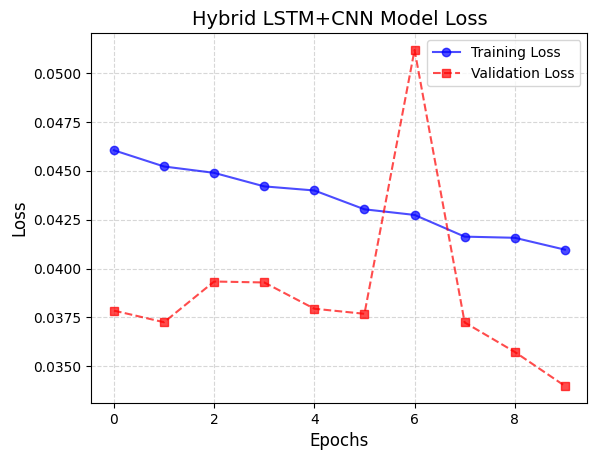

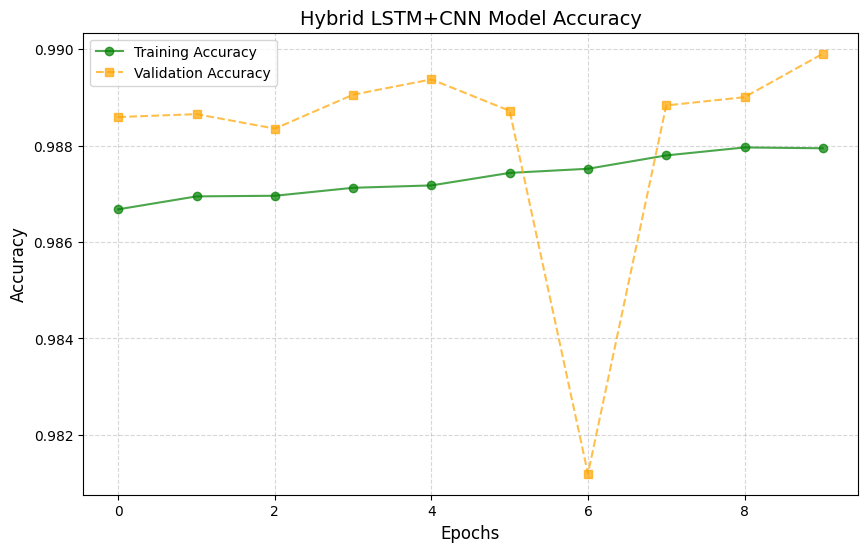

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
plt.plot(training_history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(training_history.history['val_loss'], label='Validation Loss', linestyle='--', marker='s', color='red', alpha=0.7)
plt.title('Hybrid LSTM+CNN Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', color='green', alpha=0.7)
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s', color='orange', alpha=0.7)
plt.title('Hybrid LSTM+CNN Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from google.colab import files
files.download('cnn_model.h5')
files.download('hybrid_model.h5')
files.download('scaler.save')  # optional

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final(2).csv to final(2).csv


In [ ]:
df = pd.read_csv("final(2).csv")


In [ ]:
df['Label'] = (df['Prediction'] == 'DDOS').astype(int)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Select numeric features
features = ['Time', 'BTC', 'USD', 'Netflow_Bytes', 'Port']
X = df[features]
y = df['Label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM/CNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
import joblib
from google.colab import files

# Load your dataset
df = pd.read_csv("final(2).csv")

# Create binary label: 1 if 'DDOS', else 0
df['Label'] = (df['Prediction'] == 'DDOS').astype(int)

# Select numeric features
features = ['Time', 'BTC', 'USD', 'Netflow_Bytes', 'Port']
X = df[features]
y = df['Label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split and reshape
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build hybrid model
input_layer = Input(shape=(1, X_train.shape[2]))
cnn = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
cnn = MaxPooling1D(pool_size=1)(cnn)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Conv1D(64, 3, activation='relu', padding='same')(cnn)
cnn = Flatten()(cnn)

lstm = LSTM(100, dropout=0.3, recurrent_dropout=0.2)(input_layer)

combined = concatenate([cnn, lstm])
dense = Dense(128, activation='relu')(combined)
dense = BatchNormalization()(dense)
dense = Dropout(0.4)(dense)
output = Dense(1, activation='sigmoid')(dense)

best_hybrid_model = Model(inputs=input_layer, outputs=output)
best_hybrid_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
best_hybrid_model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

# Save model and scaler
best_hybrid_model.save('hybrid_model.h5')
joblib.dump(scaler, 'scaler.save')

# Download files
files.download('hybrid_model.h5')
files.download('scaler.save')


Epoch 1/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8237 - loss: 0.4198 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 2/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9996 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 3/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 8.3482e-04
Epoch 4/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 3.9407e-04
Epoch 5/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 1.0000 - loss: 6.3724e-04 - val_accuracy: 1.0000 - val_loss: 2.5119e-04
Epoch 6/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 1.0000 - loss: 3.8995e-04 - val_accuracy: 1.0000 - val_loss: 1.5601e-04
Epoch 7/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 1.0000 - loss: 2.4786e-04 - val_accuracy: 1.0000 - val_loss: 1.0470e-04
Epoch 8/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
scaler = joblib.load("scaler.save")

scaler_json = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "feature_names": ["Time", "BTC", "USD", "Netflow_Bytes", "Port"]
}

import json
with open("scaler.json", "w") as f:
    json.dump(scaler_json, f)

from google.colab import files
files.download("scaler.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>